In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [95]:
PATH="./Datas/Grape/"
PATH_SPLITTED="./Datas/Grape_splitted/"
PATH_SHUFFLE="./Datas/shuffle/"
PATH_NEW_DATAS="./Datas/new/"
BATCH_SIZE = 64
IMG_SIZE = (160, 160)
EPOCHS = 5
INIT_LR =1e-4

In [96]:
# Copy all subdirectories of PATH to PATH_SPLITTED
import shutil
def copy_images_to_new_directory(path, path_splitted):
    for root, dirs, files in os.walk(path):
        # Get the current subdirectory name
        directory_name = os.path.basename(root)
        # Create a new directory in PATH_SPLITTED with the same name
        os.makedirs(os.path.join(path_splitted, directory_name), exist_ok=True)
        # Loop over all the files in directory
        for file in files:
            if file.endswith(".JPG"):
                shutil.copy(os.path.join(root, file), path_splitted+directory_name)

copy_images_to_new_directory(PATH, PATH_SPLITTED)

In [97]:
# In each subdirectory of PATH_SPLITTED, split the images into train and validation directories
# Do a 90/10 split
def split_images_in_directories(path, path_splitted):
    for root, dirs, files in os.walk(path):
        # Get the current subdirectory name
        directory_name = os.path.basename(root)
        # Create a new directory in PATH_SPLITTED with the same name
        os.makedirs(os.path.join(path_splitted, "train", directory_name), exist_ok=True)
        os.makedirs(os.path.join(path_splitted, "val", directory_name), exist_ok=True)
        # Loop over all the files in directory
        for file in files:
            if file.endswith(".JPG"):
                # Split each image into train and validation sets
                if np.random.rand(1) < 0.9:
                    # Copy image into path_splitted/train/directory_name/file
                    shutil.copy(os.path.join(root, file), path_splitted+"train/"+directory_name)
                else:
                    # Copy image into path_splitted/val/directory_name/file
                    shutil.copy(os.path.join(root, file), path_splitted+"val/"+directory_name)

split_images_in_directories(PATH_SPLITTED, PATH_SPLITTED)

In [102]:
# Once done, delete all subdirectories of PATH_SPLITTED except train and val
def delete_classes_subdirectories(path):
    for directory in os.listdir(path):
        if directory != "train" and directory != "val":
            shutil.rmtree(os.path.join(path, directory))
delete_classes_subdirectories(PATH_SPLITTED)

In [156]:
from CNN.common.data_generation import shuffle_images_in_directories
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# shuffle_images_in_directories(PATH+"BLACK_ROT/", PATH_SHUFFLE+"BLACK_ROT/", IMG_SIZE)
# shuffle_images_in_directories(PATH+"ESCA/", PATH_SHUFFLE+"ESCA/", IMG_SIZE)
# shuffle_images_in_directories(PATH+"HEALTHY/", PATH_SHUFFLE+"HEALTHY/", IMG_SIZE)
# shuffle_images_in_directories(PATH+"LEAF_BLIGHT/", PATH_SHUFFLE+"LEAF_BLIGHT/", IMG_SIZE)

# Load images from directories and resize them
# Load training images
train_ds = image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=PATH_SPLITTED+"train/",
    shuffle=True,
    target_size=IMG_SIZE,
    class_mode='categorical'
)

# Load validation images
val_ds = image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=PATH_SPLITTED+"val/",
    shuffle=False,
    target_size=IMG_SIZE,
    class_mode='categorical'
)

Found 3680 images belonging to 4 classes.
Found 378 images belonging to 4 classes.


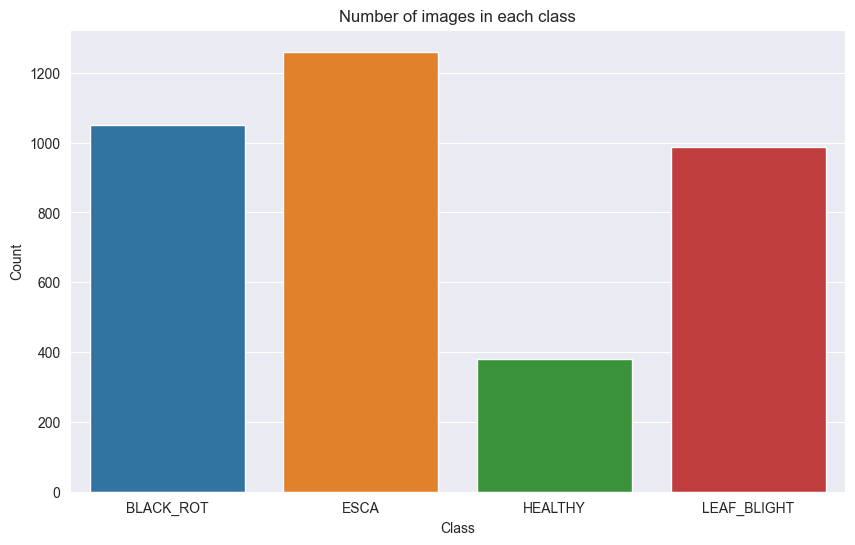

In [107]:
# Get class labels
class_labels = list(train_ds.class_indices.keys())

# Get number of images in each class
class_counts = np.bincount(train_ds.labels)

# Create a DataFrame with class labels and counts
class_counts_df = pd.DataFrame({
    'Class': class_labels,
    'Count': class_counts
})

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(data=class_counts_df, x='Class', y='Count')
plt.title('Number of images in each class')
plt.show()

In [108]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [109]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,) # R,G,B Channels
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [110]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1280)


In [ ]:
# Add a global spatial average pooling layer
out = base_model.output
out = tf.keras.layers.GlobalAveragePooling2D()(out)
out = tf.keras.layers.Dense(512, activation='relu')(out)
out = tf.keras.layers.Dense(512, activation='relu')(out)
predictions = tf.keras.layers.Dense(4, activation='softmax')(out)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers and use theyas feature extractor trained ln imagenet
for layer in base_model.layers:
    layer.trainable = False

# Compile
opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']         

In [ ]:
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

6/6 [==============================] - 4s 463ms/step - loss: 1.5601 - accuracy: 0.2407
initial loss: 1.56
initial accuracy: 0.24


In [ ]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)

Epoch 1/5
58/58 [==============================] - 25s 373ms/step - loss: 0.3945 - accuracy: 0.8769 - val_loss: 0.1252 - val_accuracy: 0.9735
Epoch 2/5
58/58 [==============================] - 4s 73ms/step - loss: 0.0876 - accuracy: 0.9747 - val_loss: 0.0858 - val_accuracy: 0.9735
Epoch 3/5
58/58 [==============================] - 4s 71ms/step - loss: 0.0542 - accuracy: 0.9842 - val_loss: 0.0721 - val_accuracy: 0.9709
Epoch 4/5
58/58 [==============================] - 4s 72ms/step - loss: 0.0370 - accuracy: 0.9910 - val_loss: 0.0658 - val_accuracy: 0.9656
Epoch 5/5
58/58 [==============================] - 4s 72ms/step - loss: 0.0268 - accuracy: 0.9954 - val_loss: 0.0646 - val_accuracy: 0.9656


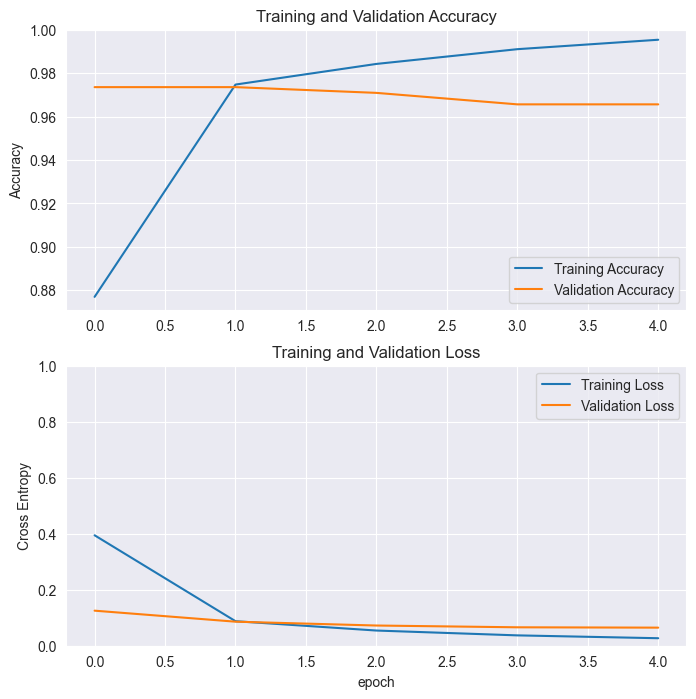

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [115]:
base_model.trainable = True

In [116]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [117]:
fine_tune_epochs = 5
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 5/10
58/58 [==============================] - 4s 75ms/step - loss: 0.0206 - accuracy: 0.9967 - val_loss: 0.0585 - val_accuracy: 0.9735
Epoch 6/10
58/58 [==============================] - 4s 74ms/step - loss: 0.0174 - accuracy: 0.9965 - val_loss: 0.0533 - val_accuracy: 0.9815
Epoch 7/10
58/58 [==============================] - 4s 73ms/step - loss: 0.0109 - accuracy: 0.9997 - val_loss: 0.0532 - val_accuracy: 0.9815
Epoch 8/10
58/58 [==============================] - 4s 72ms/step - loss: 0.0086 - accuracy: 0.9997 - val_loss: 0.0517 - val_accuracy: 0.9815
Epoch 9/10
58/58 [==============================] - 4s 73ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0520 - val_accuracy: 0.9815
Epoch 10/10
58/58 [==============================] - 4s 72ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0514 - val_accuracy: 0.9841


In [118]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

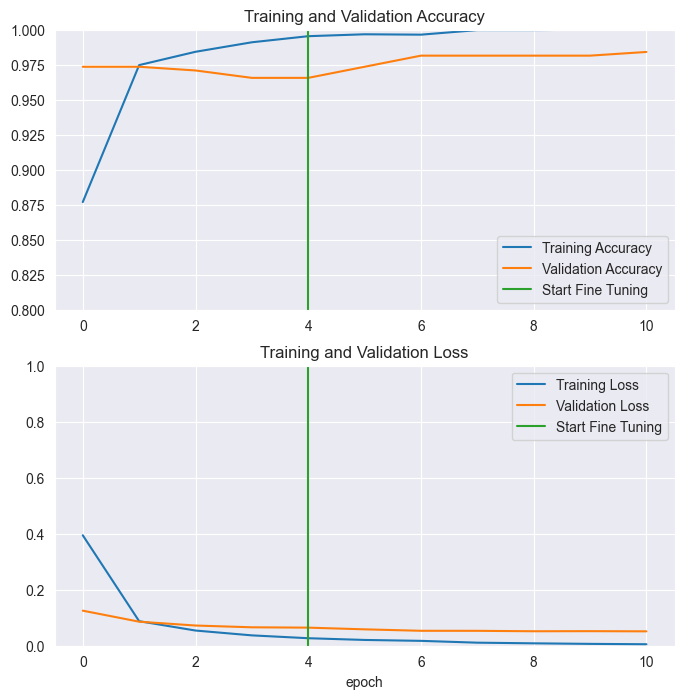

In [119]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [120]:
final_loss, final_accuracy = model.evaluate(val_ds)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}".format(final_accuracy))

6/6 [==============================] - 0s 65ms/step - loss: 0.0514 - accuracy: 0.9841
Final loss: 0.05
Final accuracy: 0.98


In [121]:
model.save('model.h5')

In [122]:
# Load the model
model = tf.keras.models.load_model('model.h5')

In [123]:
# Evaluate the model
loss, acc = model.evaluate(val_ds)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

6/6 [==============================] - 1s 73ms/step - loss: 0.0514 - accuracy: 0.9841
Restored model, accuracy: 98.41%
0.05138523876667023


In [158]:
# Predict on a random image inside PATH_SPLITTED validation folder
import random
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

# Get random image
path = 'Datas/Grape_splitted/val/'
random_subfolder = random.choice(os.listdir(path))
random_image = random.choice(os.listdir(path + random_subfolder))
img_path = path + random_subfolder + '/' + random_image

# Load image
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create batch axis

# Preprocess image
img_preprocessed = preprocess_input(img_array)

# Evaluate image
single_prediction = model.predict(img_preprocessed)
score = tf.nn.softmax(single_prediction[0])

# Print true class
print("True class: {}".format(random_subfolder))
# Print predicted class
print("Predicted class: {}".format(class_labels[np.argmax(score)]))
# Print top 4 predictions
print("Top 4 predictions:")
for i in single_prediction.argsort()[0][-4:][::-1]:
    print(" {} - {:.2f}%".format(class_labels[i], 100 * single_prediction[0][i]))

1/1 [==============================] - 0s 31ms/step
True class: ESCA
Predicted class: ESCA
Confidence score: 47.53668010234833
Top 4 predictions:
 ESCA - 100.00%
 LEAF_BLIGHT - 0.00%
 BLACK_ROT - 0.00%
 HEALTHY - 0.00%


6/6 [==============================] - 1s 119ms/step


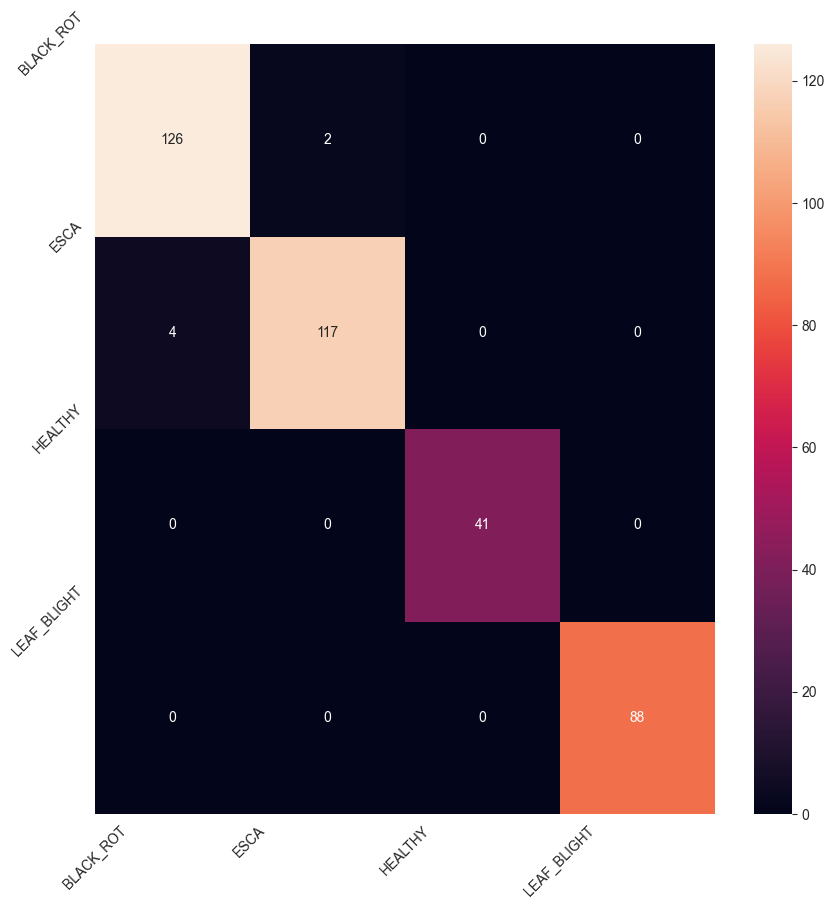

In [161]:
from sklearn.metrics import confusion_matrix
# Get predictions for images in val_ds
predictions = model.predict(val_ds, )

# Get predicted class for each image if val_ds
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes for each image in val_ds
true_classes = val_ds.classes

# Get class labels
class_labels = list(val_ds.class_indices.keys())

# Print true vs predicted classes
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.xticks(np.arange(4), class_labels, rotation=45)
plt.yticks(np.arange(4), class_labels, rotation=45)
plt.show()

In [162]:
# Print classification report
from sklearn.metrics import classification_report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

   BLACK_ROT       0.97      0.98      0.98       128
        ESCA       0.98      0.97      0.97       121
     HEALTHY       1.00      1.00      1.00        41
 LEAF_BLIGHT       1.00      1.00      1.00        88

    accuracy                           0.98       378
   macro avg       0.99      0.99      0.99       378
weighted avg       0.98      0.98      0.98       378

